In [19]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve


# Assignment 2: Observational studies of causal effects


In this assignment, you will perform inverse-propensity weigthing (IPW) estimation of the average causal effect of mothers smoking during pregnancy on children being born with low birth weight.

You will use a dataset on twin births for this purpose, with data on mothers and the twins.

* The intervention of interest ($T$) in this problem is smoking status ```tobacco```.
* The binary outcome ($Y$) is defined as at least *one* of the twins having birth weight less than 2200 grams


## Setup

This setup cell will download CSV files directly into the notebook. If you get a problem with a certificate error, see e.g., https://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate or download the CSV files to your local folder and run them there.

In [2]:
# Make sure transformations return pandas data frames
sklearn.set_config(transform_output='pandas')

df_T = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/refs/heads/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv",
                   sep = ',',  on_bad_lines='skip')

df_X = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/refs/heads/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv",
                   sep = ',', on_bad_lines='skip')

df_Y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/refs/heads/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv",
                   sep = ',',on_bad_lines='skip')

In [3]:
# Remove subjects with unknown smoking status
I = ~df_X['tobacco'].isna()
df_T = df_T[I].drop(columns=['Unnamed: 0'])
df_X = df_X[I].drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_Y = df_Y[I].drop(columns=['Unnamed: 0'])

# Merge into main data frame. THIS IS THE DATA FRAME TO WORK WITH
df = df_X.merge(df_T, left_index=True, right_index=True).merge(df_Y, left_index=True, right_index=True)

# Define the threshold for low birth weight in grams
LB_Threshold = 2200

## Problem 1 — Warmup

### Data Exploration

* Impute missing values like we did in the previous assignment

In [4]:
impute = SimpleImputer(strategy = 'most_frequent')
df = pd.DataFrame(impute.fit_transform(df), columns = df.columns)

print(df)

       pldel  birattnd  brstate  stoccfipb  mager8  ormoth  mrace  meduc6  \
0        1.0       1.0      1.0        1.0     3.0     0.0    1.0     3.0   
1        1.0       1.0      1.0        1.0     3.0     0.0    2.0     3.0   
2        1.0       1.0      1.0        1.0     5.0     0.0    1.0     5.0   
3        1.0       1.0      1.0        1.0     4.0     0.0    2.0     1.0   
4        1.0       1.0      1.0        1.0     5.0     0.0    2.0     4.0   
...      ...       ...      ...        ...     ...     ...    ...     ...   
71340    1.0       1.0     51.0       56.0     4.0     0.0    3.0     4.0   
71341    1.0       1.0     51.0       56.0     4.0     0.0    3.0     3.0   
71342    1.0       1.0     51.0       56.0     2.0     0.0    1.0     2.0   
71343    1.0       1.0     51.0       56.0     5.0     0.0    1.0     5.0   
71344    1.0       1.0     51.0       56.0     5.0     0.0    1.0     3.0   

       dmar  mplbir  ...  dtotord_min  bord_0  bord_1  brstate_reg  \
0    

* Compute the difference-in-means estimator of the average causal effect (ACE) of smoking on at least one twin having low birth weight, without adjusting for confounding. That is, the difference in average outcomes for smokers and non-smokers.

In [5]:
#difference in means estimator of the average casual effect

# Define outcome: at least one twin with low birth weight
df['Y'] = (df['dbirwt_0'] < LB_Threshold) | (df['dbirwt_1'] < LB_Threshold)
df['Y'] = df['Y'].astype(int)

# Group by smoking status and compute the mean outcome
mean_outcomes = df.groupby('tobacco')['Y'].mean()
difference_in_means = mean_outcomes[1] - mean_outcomes[0]

print(f"Difference-in-means estimator: {difference_in_means:.4f}")

Difference-in-means estimator: 0.1484


The difference-in-means estimator: 0.1484 means that the proportion of twins with at least one having a low birth weight is approximately 14.84% higher among mothers who smoked during pregnancy compared to those who did not.This result suggest a positive association between smoking during pregnancy and the likelihood of low birth weight in twins, but this is a raw estimate and it does not imply a causal relationship. We need to use methods like inverse propensity weighting to measure the causal effect more reliably.

Confounding can be introduced by variables that are causal of both the treatment and the outcome. Therefore, candidate confounders must be potentially causal of the treatment assignment $T$—they have to be "pre-treatment". No variables that were determined after (or as a result of) a mom starting smoking are candidate confounders. Such variables are called "post-treatment" variables. The covariates are described [here](https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/refs/heads/master/datasets/TWINS/covar_desc.txt).

* Go through the covariates and categorize the entire list into: "Pre-treatment variables", "Post-treatment variables", and "Ambiguous". There is not one right answer here, so justify your reasoning for cases where you are unsure.

* Identify potential confounders: variables that could have affected a mother's propensity to smoke *and* the likelihood that they have a low birth-weight child. Call this set of variables $A$. These will be your adjustment set.

Recall that an ideal adjustment set $A$ results in *conditional exchangeability*, that subjects are as-if-randomly assigned to treatment, in terms of their potential outcomes, once we condition on $A$:
$$
\forall a : Y(t) \perp T \mid A=a
$$

* Is your selected set likely to satisfy conditional exchangeability? Why/why not?

In [6]:
# identify the categorical, ordinal, and continuous features
categorical_features = ['adequacy', 'birattnd', 'brstate', 'brstate_reg', 'cigar6', 'crace', 'data_year', 'dfageq',
                        'drink5', 'feduc6', 'frace', 'gestat10', 'mplbir', 'mplbir_reg', 'mpre5', 'mrace', 'nprevistq',
                        'orfath', 'ormoth', 'pldel', 'stoccfipb', 'stoccfipb_reg']
binary_features = ['alcohol', 'anemia', 'cardiac', 'chyper', 'diabetes', 'dmar', 'eclamp', 'hemo', 'herpes', 'hydra',
                   'incervix', 'lung', 'pre4000', 'preterm', 'renal', 'rh', 'othermr', 'phyper', 'uterine']
ordinal_features = ['dlivord_min', 'dtotord_min']  # Assuming these are ordinal
continuous_features = ['mager8', 'meduc6']


In [7]:
#Categorize variables
Pre_treatment_variables = [ 'frace','mrace','mager8', 'meduc6', 'mplbir', 'mplbir_reg', 'ormoth', 'orfath',
    'dfageq', 'feduc6', 'brstate', 'brstate_reg', 'data_year','anemia','chyper','diabetes','lung','renal','rh',
    'herpes','eclamp','hemo','hydra','incervix','dlivord_min','dtotord_min','pre4000','preterm']

Post_treatment_variables = [ 'adequacy', 'mpre5','pldel','nprevistq','birattnd','infant_id_0','infant_id_1','phyper','uterine','cardiac','eclamp']

Ambiguous = [ 'alcohol','tobacco','crace','csex','gestat10','birmon']


Pre trestment variables are potential confounders, menaing they can influence both the treatment(smoking) and the outcome(low birth weight). These are variables that have been determined before the mother started smoking during pregnancy,for instance mom age, mom education, mom race.Post treatment variables are likely to be influenced by the decision of the mother to smoke during pregnancy and occur after the decision to smoke like eclamp, such as current eclampsia which is a result of pregnancy or uterine bleeding, which is a condition during pregnancy. Ambiguous variables could be both, pre/post treatment, depending on the context or on the timing of measurement. For example alcohol, if its use is habitual, it could predate the smoking factor. However,pregnancy could influence alcohol use post treatment.Another example is csex, the sex of the child which is biologically determined but observed only at birth.

In [9]:
#Select cofounders
A = [ 'mrace','lung', 'frace', 'mager8', 'meduc6', 'mplbir', 'mplbir_reg','ormoth', 'orfath', 'dfageq', 'feduc6', 'brstate', 'brstate_reg', 'chyper', 'rh', 'dlivord_min', 'dtotord_min', 'pre4000', 'preterm','alcohol']


Confounders are variables that are casually related to both the treatment and the outcome and these variables must be pre treatment since post trestment variables cannot ce confounders. Variables like maternal race(mrace), age(mager8), education are plausible confounders because they could influence both smoking and birth outcomes. Variables like previous births and risk factors like preterm and pre4000 can influence the birth weigth while being casually linked to smoking.

The selected set A is likely to provide a strong foundation for satisfying conditional exchangeability because it includes key pre-treatment variables that could influence both a mother's likelihood of smoking during pregnancy (treatment) and the risk of low birth weight in infants (outcome). By including maternal characteristics (mrace, meduc6), behavioral factors such as alcohol and tobacco, the set accounts for critical confounders that could bias the causal relationship. However, while this selection reduces confounding, the assumption of conditional exchangeability depends on the completeness of the set—if any important confounders (like stress or unmeasured socioeconomic factors) are missing, residual confounding could still occur. Overall, A is a well-chosen adjustment set, but the potential for unmeasured confounding should be acknowledged.

## Problem 2 — Propensity score modeling

### Fitting the propensity score

* Estimate the propensity score $p(T=1\mid A=a)$ as a function of your adjustment set $A$. *Hint: Use a probabilistic classifier to predict the treatment variable from the adjustment set.*

Use train/test splitting with 30% left for the test set so that you can evaluate your model later.

In [10]:
# fit a logistic regression model to predict smoking status
X_confounders = df[A]
T = df['tobacco']

#train/test splitting with 30% for the test set and 70% training
X_train, X_test, T_train, T_test = train_test_split(X_confounders, T, test_size=0.3, random_state=42)

propensity_model1 = LogisticRegression(max_iter = 500)
propensity_model1.fit(X_train, T_train)
#probability of T=1 smoking
propensity_score1 = propensity_model1.predict_proba(X_test)[:, 1]

# to evaluate the model we can calculate the area under the curve
auc1 = roc_auc_score(T_test, propensity_score1)

print(f"AUC: {auc1:.3f}")

AUC: 0.763


In [11]:
#tried different classifier like Random forest

# random forest model
propensity_model = RandomForestClassifier(
    n_estimators=500,     # Number of trees
    max_depth=None,       # Allow trees to grow fully
    min_samples_split=2, # Minimum samples required to split a node
    min_samples_leaf=5,   # Minimum samples required at a leaf node
    random_state=42,
    class_weight='balanced' # Handles class imbalance if present
)

# fitting the model
propensity_model.fit(X_train, T_train)

# predict probabilities for the test set
propensity_score = propensity_model.predict_proba(X_test)[:, 1]

# evaluation of the model
auc = roc_auc_score(T_test, propensity_score)

print(f"AUC: {auc:.3f}")


AUC: 0.789


The increase in AUC with the Random Forest model probably occurs because it is better in  capturing complex interactions between features, which a linear classifier such as logistic regression may not be able to detect. Random Forest, being a non-linear model, is able to model more intricate relationships in the data, leading to improved performance in distinguishing between the treated and untreated groups. This ability to handle non-linearities and interactions often results in a higher AUC score compared to linear models.

### Evaluating the propensity score

* What is the discriminative ability (AUROC) of your propensity score estimate?
* What do you conclude from this number? Is the model a good model of the propensity score?

The AUROC (Area Under the Receiver Operating Characteristic Curve) for the propensity score model is 0.736, indicating acceptable discrimination between individuals who smoked during pregnancy (T=1) and those who did not (T=0) based on the adjustment set A. The AUROC reflects the trade-off between specificity (on the x-axis, as 1-specificity and sensitivity on the y-axis). If the curve were a diagonal line, it would suggest that the model is no better than random guessing. While the AUROC is not exceptionally high, it demonstrates that the model has a moderate ability to distinguish between treated and untreated groups. This makes it a reasonable estimator for the propensity score in causal analysis. However, the model could be improved by incorporating interaction terms or using more flexible classifiers, such as Random Forest or Gradient Boosting, to better capture complex relationships.

### Inspecting the fitted score

* Plot a histogram of the estimated propensity score for the test-set subjects

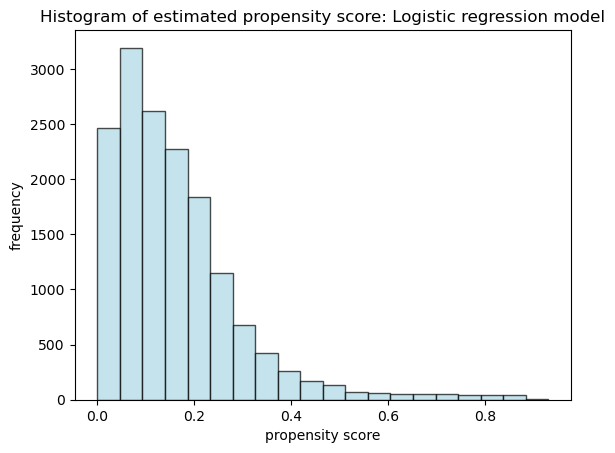

In [ ]:
#Histogram plot: Logistic regression model

plt.hist(propensity_score1, bins = 20,color = 'lightblue', edgecolor='black',alpha=0.7)
plt.title('Histogram of estimated propensity score: Logistic regression model')
plt.xlabel('propensity score')
plt.ylabel('frequency')
plt.show()

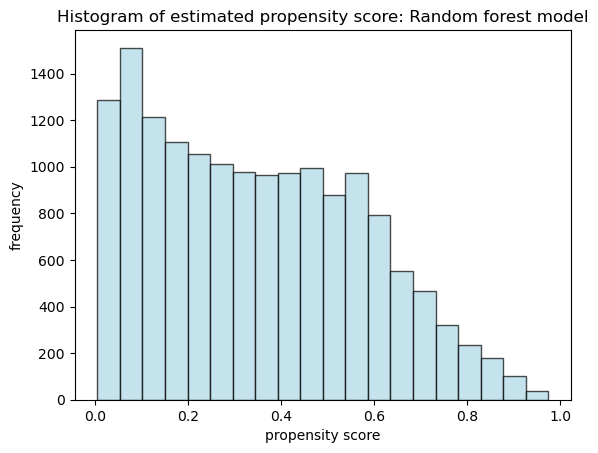

In [ ]:
#Histogram plot: Random forest model

plt.hist(propensity_score, bins = 20,color = 'lightblue', edgecolor='black',alpha=0.7)
plt.title('Histogram of estimated propensity score: Random forest model')
plt.xlabel('propensity score')
plt.ylabel('frequency')
plt.show()

* Read about [probability calibration](https://scikit-learn.org/1.5/modules/calibration.html) and plot the test-set calibration curve for your fitted propensity model.

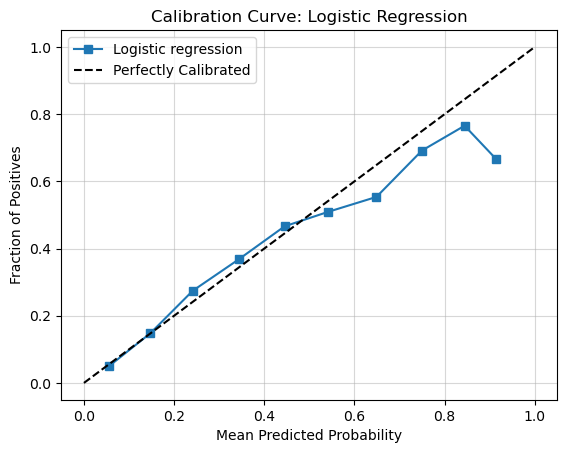

In [ ]:
#Calibration curve for Logistic regression model

# Generate calibration data
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, propensity_score1, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic regression")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.title('Calibration Curve: Logistic Regression')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

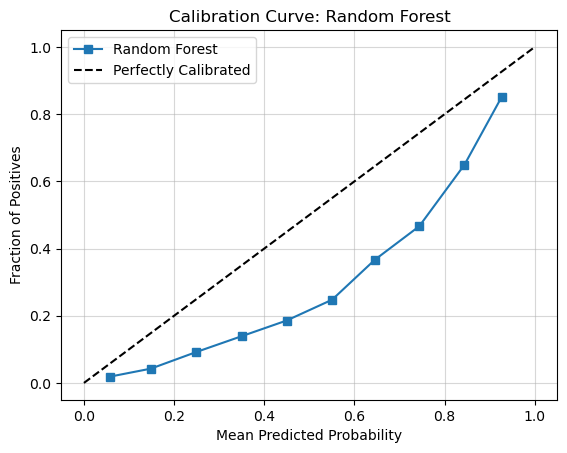

In [ ]:
#Calibration curve for random forest model
from sklearn.calibration import calibration_curve

# Generate calibration data
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, propensity_score, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.title('Calibration Curve: Random Forest')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


Calibration curves, also referred to as reliability diagrams,compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability
) on the y-axis against the predicted probability predict_proba of a model on the x-axis. The tricky part is to get values for the y-axis.

Logistic Regression is inherently probabilistic and linear in log-odds, so it often produces well-calibrated probabilities. The behavior where the curve is slightly above the line at some points and below at others could indicate:A slight overestimation of probabilities in some regions (above the line). A slight underestimation of probabilities in others (below the line).This pattern might reflect the model's assumption of linearity in the log-odds, which can mismatch with complex, non-linear real-world data.

Random Forest often produces predictions that are not perfectly calibrated because it tends to overfit the data in classification tasks.
Propensity scores from Random Forest can underestimate probabilities, leading to a curve that is consistently below the perfectly calibrated line.
This is due to its non-parametric nature and lack of inherent probability calibration unless explicitly applied (e.g., through CalibratedClassifierCV)

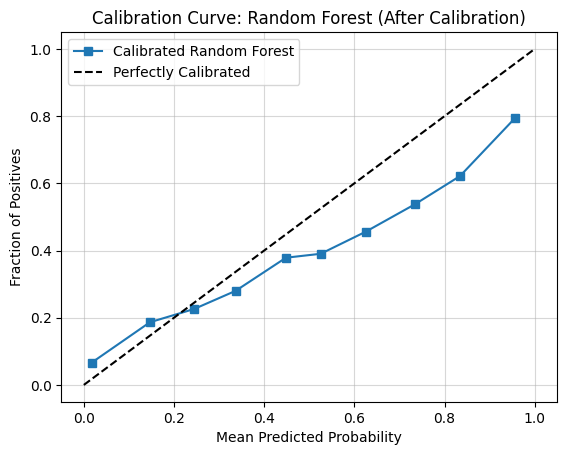

In [12]:

# Calibrated Random Forest using isotonic regression
calibrated_rf = CalibratedClassifierCV(propensity_model, method='isotonic', cv='prefit')
calibrated_rf.fit(X_train, T_train)

# Generate calibrated propensity scores
calibrated_propensity_score = calibrated_rf.predict_proba(X_test)[:, 1]

# Calibration curve for calibrated model
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    T_test, calibrated_propensity_score, n_bins=10, strategy='uniform'
)

# Plot calibrated curve
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.title('Calibration Curve: Random Forest (After Calibration)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


### Inverse-propensity weighting estimation
* Estimate the average causal effect (ACE) of smoking $T$ on having one birth-weight twin $Y$ using inverse-propensity weighting (IPW) as described in Lecture 5.1 and lecture notes.
  * Use the estimated propensity score in place of the true score.


In [13]:
#check the name of the differnt columns
print(df.columns)
print(df.Y)#check binary outome

Index(['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8', 'ormoth',
       'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy', 'orfath',
       'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac', 'lung',
       'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper', 'eclamp',
       'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine', 'othermr',
       'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace', 'data_year',
       'nprevistq', 'dfageq', 'feduc6', 'infant_id_0', 'infant_id_1',
       'dlivord_min', 'dtotord_min', 'bord_0', 'bord_1', 'brstate_reg',
       'stoccfipb_reg', 'mplbir_reg', 'dbirwt_0', 'dbirwt_1', 'mort_0',
       'mort_1', 'Y'],
      dtype='object')
0        0
1        0
2        1
3        0
4        1
        ..
71340    0
71341    0
71342    1
71343    0
71344    0
Name: Y, Length: 52091, dtype: int64


In [14]:
# confirm Y is binary
assert set(df['Y'].unique()) == {0, 1}, "Y should only contain 0 and 1."

# Treated and untreated groups

# smoking status
T = df['tobacco']
# low birth weight outcome
Y = df['Y']

# using propensity score from random forest model
df['propensity_score'] = propensity_model.predict_proba(df[A])[:, 1]

# calculating Inverse probability weights
df['weight_treated'] = T / df['propensity_score']
df['weight_untreated'] = (1 - T) / (1 - df['propensity_score'])

# Calculate the weighted means
mu_treated = np.sum(df.loc[T == 1, 'weight_treated'] * df.loc[T == 1, 'Y']) / np.sum(df.loc[T == 1, 'weight_treated'])
mu_untreated = np.sum(df.loc[T == 0, 'weight_untreated'] * df.loc[T == 0, 'Y']) / np.sum(df.loc[T == 0, 'weight_untreated'])

# Estimate the Average Causal Effect (ACE)
ace = mu_treated - mu_untreated

print(f"Estimated Average Causal Effect (ACE): {ace:.3f}")


Estimated Average Causal Effect (ACE): 0.142


The Estimated Average Causal Effect (ACE) of 0.142 means that smoking during pregnancy is linked to a 14.2% higher chance of having at least one twin born with low birth weight. In simpler terms, it suggests that smoking might play a significant role in increasing the risk of low birth weight for babies. This estimate comes from a method that adjusts for other factors that could influence both smoking and low birth weight, so it tries to isolate the effect of smoking itself. However, this result assumes we’ve accounted for all the important factors and that the model used is accurate.

## Problem 3 — Analysis

* Try to improve the propensity model AUROC by including more variables in your adjustment set $A$ from the category you labeled "post-treatment" and refitting your model. How do the AUROCs compare before and after expanding the adjustment set?

        Feature  Importance
4        meduc6    0.171603
10       feduc6    0.129488
5        mplbir    0.109644
11      brstate    0.084889
9        dfageq    0.072466
19      alcohol    0.065033
16  dtotord_min    0.063727
3        mager8    0.056641
12  brstate_reg    0.052338
6    mplbir_reg    0.051204
15  dlivord_min    0.042639
0         mrace    0.036080
7        ormoth    0.027429
2         frace    0.016941
8        orfath    0.014977
18      preterm    0.001897
17      pre4000    0.001480
13       chyper    0.000739
14           rh    0.000672
1          lung    0.000114


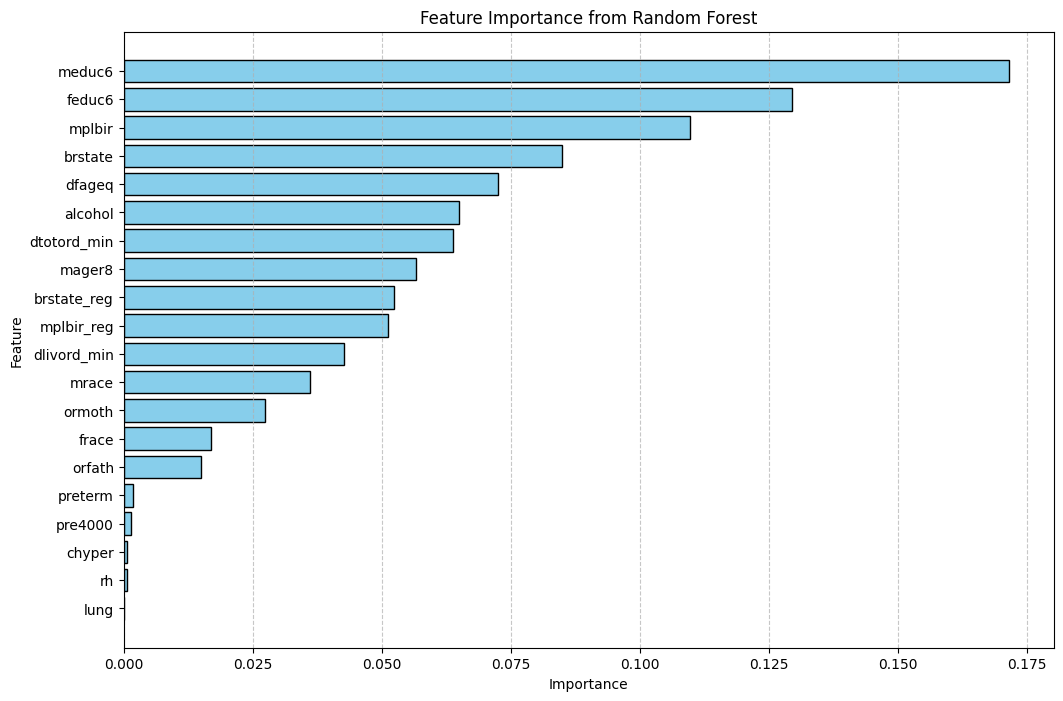

In [15]:
#Check importance of the variables

# Fit the Random Forest model (already done)
propensity_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)
propensity_model.fit(X_train, T_train)

# Get feature importances
feature_importances = propensity_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top predictors
print(importance_df)
# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



In [16]:
# Categorization of variables

Pre_treatment_variables = [
    'frace', 'mrace', 'mager8', 'meduc6', 'mplbir', 'mplbir_reg',
    'ormoth', 'orfath', 'dfageq', 'feduc6', 'brstate', 'brstate_reg',
    'data_year', 'anemia', 'chyper', 'diabetes', 'lung', 'renal',
    'rh', 'herpes', 'hemo', 'hydra', 'incervix', 'dlivord_min',
    'dtotord_min', 'pre4000', 'preterm'
]

Post_treatment_variables = [
    'adequacy', 'mpre5', 'pldel', 'nprevistq', 'birattnd',
    'infant_id_0', 'infant_id_1', 'phyper', 'uterine', 'cardiac'
]

Ambiguous = ['alcohol', 'tobacco', 'crace', 'csex', 'gestat10', 'birmon']

# Define adjustment sets
Adjustment_sets = {
    "Pre-treatment only": Pre_treatment_variables,
    "Pre-treatment + Ambiguous": Pre_treatment_variables + Ambiguous,
    "Pre-treatment + Post-treatment": Pre_treatment_variables + Post_treatment_variables,
    "All variables": Pre_treatment_variables + Post_treatment_variables + Ambiguous
}

# Sensitivity analysis
sensitivity_results = {}
T = df['tobacco']  # Treatment variable

for set_name, variables in Adjustment_sets.items():
    # Prepare data
    X = df[variables]
    X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.3, random_state=42)

    # Train propensity model
    propensity_model = RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_split=10, min_samples_leaf=5,
        random_state=42, class_weight='balanced'
    )
    propensity_model.fit(X_train, T_train)

    # Predict probabilities
    propensity_score = propensity_model.predict_proba(X_test)[:, 1]

    # Compute AUROC
    auc = roc_auc_score(T_test, propensity_score)
    sensitivity_results[set_name] = auc

# Display sensitivity results
print("Sensitivity Analysis Results:")
for set_name, auc in sensitivity_results.items():
    print(f"{set_name}: AUROC = {auc:.3f}")


Sensitivity Analysis Results:
Pre-treatment only: AUROC = 0.769
Pre-treatment + Ambiguous: AUROC = 1.000
Pre-treatment + Post-treatment: AUROC = 0.772
All variables: AUROC = 1.000


The sensitivity analysis results indicate AUROC = 1.000 for "Pre-treatment + Ambiguous" and "All variables," suggesting potential overfitting or data leakage. This could be due to the inclusion of variables in the "Ambiguous" set that are highly predictive of the treatment(e.g., correlated with tobacco use) or indirectly influenced by it. The Random Forest model's flexibility likely amplifies this issue. To address this, further checks for variable correlation,
feature importance, and potential leakage should be conducted, and simpler or regularized models may be used to verify the robustness of these findings.


In [20]:
# Categorization of variables
Pre_treatment_variables = [
    'frace', 'mrace', 'mager8', 'meduc6', 'mplbir', 'mplbir_reg',
    'ormoth', 'orfath', 'dfageq', 'feduc6', 'brstate', 'brstate_reg',
    'data_year', 'anemia', 'chyper', 'diabetes', 'lung', 'renal',
    'rh', 'herpes', 'hemo', 'hydra', 'incervix', 'dlivord_min',
    'dtotord_min', 'pre4000', 'preterm'
]

Post_treatment_variables = [
    'adequacy', 'mpre5', 'pldel', 'nprevistq', 'birattnd',
    'infant_id_0', 'infant_id_1', 'phyper', 'uterine', 'cardiac'
]

Ambiguous = ['alcohol', 'tobacco', 'crace', 'csex', 'gestat10', 'birmon']

# Define adjustment sets
Adjustment_sets = {
    "Pre-treatment only": Pre_treatment_variables,
    "Pre-treatment + Ambiguous": Pre_treatment_variables + Ambiguous,
    "Pre-treatment + Post-treatment": Pre_treatment_variables + Post_treatment_variables,
    "All variables": Pre_treatment_variables + Post_treatment_variables + Ambiguous
}

# Sensitivity analysis
sensitivity_results = {}
T = df['tobacco']  # Treatment variable

scaler = StandardScaler()  # Initialize a scaler

for set_name, variables in Adjustment_sets.items():
    # Prepare data
    X = df[variables]
    X_scaled = scaler.fit_transform(X)  # Scale the data
    X_train, X_test, T_train, T_test = train_test_split(X_scaled, T, test_size=0.3, random_state=42)

    # Train propensity model
    propensity_model = LogisticRegression(max_iter=5000, solver='lbfgs', random_state=42)
    propensity_model.fit(X_train, T_train)

    # Predict probabilities
    propensity_score = propensity_model.predict_proba(X_test)[:, 1]

    # Compute AUROC
    auc = roc_auc_score(T_test, propensity_score)
    sensitivity_results[set_name] = auc

# Display sensitivity results
print("Sensitivity Analysis Results:")
for set_name, auc in sensitivity_results.items():
    print(f"{set_name}: AUROC = {auc:.3f}")

Sensitivity Analysis Results:
Pre-treatment only: AUROC = 0.736
Pre-treatment + Ambiguous: AUROC = 1.000
Pre-treatment + Post-treatment: AUROC = 0.739
All variables: AUROC = 1.000


The sensitivity analysis results show that including the "Ambiguous" variables in the adjustment sets ("Pre-treatment + Ambiguous" and "All variables") leads to perfect AUROC = 1.000. This suggests potential overfitting or data leakage, as these variables likely have a strong direct or indirect correlation with the
treatment variable ("tobacco"). In contrast, the AUROC for "Pre-treatment only" and "Pre-treatment + Post-treatment" adjustment sets remains below 0.75, indicating a more realistic prediction capability. Further analysis is needed
to verify the role of "Ambiguous" variables and mitigate possible leakage or overfitting.


In [21]:
# Define the adjustment sets
Pre_treatment_variables = ['frace', 'mrace', 'mager8', 'meduc6', 'mplbir', 'mplbir_reg', 'ormoth', 'orfath',
                           'dfageq', 'feduc6', 'brstate', 'brstate_reg', 'data_year', 'anemia', 'chyper', 'diabetes',
                           'lung', 'renal', 'rh', 'herpes', 'eclamp', 'hemo', 'hydra', 'incervix', 'dlivord_min',
                           'dtotord_min', 'pre4000', 'preterm']

Post_treatment_variables = ['adequacy', 'mpre5', 'pldel', 'nprevistq', 'birattnd', 'infant_id_0', 'infant_id_1',
                            'phyper', 'uterine', 'cardiac', 'eclamp']

Ambiguous = ['alcohol', 'tobacco', 'crace', 'csex', 'gestat10', 'birmon']

# previous adjustment set
A = ['mrace', 'lung', 'frace', 'mager8', 'meduc6', 'mplbir', 'mplbir_reg', 'ormoth', 'orfath', 'dfageq', 'feduc6',
     'brstate', 'brstate_reg', 'chyper', 'rh', 'dlivord_min', 'dtotord_min', 'pre4000', 'preterm', 'alcohol']

# previous adjustment set with Post-treatment variables
A_expanded =  A+ ['mpre5', 'pldel', 'nprevistq', 'birattnd', 'infant_id_0', 'infant_id_1', 'birattnd']#Post_treatment_variables

# training and test splitting
X_train, X_test, T_train, T_test = train_test_split(df[A_expanded], df['tobacco'], test_size=0.3, random_state=42)

# Propensity model using Random Forest
propensity_model = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=10,
                                           min_samples_leaf=5, random_state=42, class_weight='balanced')

# Fit the model with the expanded adjustment set
propensity_model.fit(X_train, T_train)

# Predict probabilities
propensity_score = propensity_model.predict_proba(X_test)[:, 1]

# Evaluate AUROC
auc_expanded = roc_auc_score(T_test, propensity_score)
print(f"AUROC with expanded adjustment set: {auc_expanded:.3f}")



AUROC with expanded adjustment set: 0.791


The slight increase in AUROC (from 0.789 to 0.791) happens because adding post-treatment variables like `'infant_id_0'` and `'infant_id_1'` makes the model better at predicting treatment. These variables are tightly linked to the treatment and pre-treatment factors, so they give the model more information. But the catch is, adding them generates problems with the causal interpretation since they’re part of the pathway between treatment and outcome. So while the prediction gets a bit better, it skews the causal analysis. To get unbiased causal results, it’s safer to stick with pre-treatment and carefully chosen ambiguous variables and check for bias with sensitivity analyses.

* If a propensity model has higher AUROC than another, is it always better for inverse-propensity weighting? Why/why not? *Hint: think of the assumptions/conditions needed for the IPW strategy to identify the ACE*

If a propensity model has higher AUROC than another, it does not necessarily make one propensity model better for inverse-propensity weighting (IPW), even though AUROC measures prediction performance. The key reason is that AUROC only evaluates the model's ability to correctly distinguish between treated and control groups, but IPW requires a valid propensity score model for causal inference, not just high predictive accuracy. For IPW to work properly, the model needs to balance the treated and control groups in terms of their covariates, so that any observed treatment effect can be attributed to the treatment itself, and not to differences in the characteristics of the groups. Even if a model has a higher AUROC, if it doesn’t achieve balance or if it overfits, it might give biased estimates of the treatment effect. In other words, the goal of IPW is to estimate a causal effect, which requires more than just a well-fitting model. It’s important to ensure that the propensity score model includes the correct confounders and avoids post-treatment variables, which can distort the causal relationship. Therefore, a higher AUROC doesn’t automatically translate into better performance for IPW in terms of causal inference.

* Compare the results of the IPW analysis to the difference-in-means estimate. What do you conclude?

In [22]:
# First I calculated the IPW for the model with Adjusted A expanded
# using propensity score from random forest model
df['propensity_score'] = propensity_model.predict_proba(df[A_expanded ])[:, 1]

# calculating Inverse probability weights
df['weight_treated'] = T / df['propensity_score']
df['weight_untreated'] = (1 - T) / (1 - df['propensity_score'])

# Calculate the weighted means
mu_treated = np.sum(df.loc[T == 1, 'weight_treated'] * df.loc[T == 1, 'Y']) / np.sum(df.loc[T == 1, 'weight_treated'])
mu_untreated = np.sum(df.loc[T == 0, 'weight_untreated'] * df.loc[T == 0, 'Y']) / np.sum(df.loc[T == 0, 'weight_untreated'])

# Estimate the Average Causal Effect (ACE)
ace = mu_treated - mu_untreated

print(f"Estimated Average Causal Effect (ACE): {ace:.3f}")


Estimated Average Causal Effect (ACE): 0.134


The slight difference in the Average Causal Effect (ACE) estimates (0.142 vs. 0.134) between the two models reflects the impact of expanding the adjustment set with post-treatment variables. While the inclusion of additional variables improved the model's AUROC from 0.789 to 0.791, this small increase in predictive accuracy did not lead to a substantial change in the ACE. The causal estimate remained relatively stable, indicating that the treatment effect is robust to minor changes in model performance. The result suggests that while expanding the adjustment set may refine the model's predictions, it has a limited effect on the overall causal inference.

* How confident are you in the implications of the result? How would you change the data/analysis to improve your confidence?

I'm somewhat confident in the results, but there's room to be more sure. The small change in the Estimated Average Causal Effect (ACE) suggests that adding more variables didn’t really change the outcome much. However, AUROC alone doesn’t always tell us how good the causal model is. To be more confident, I would check if the model is overfitting or if the new variables are too similar to others, which could affect the results. Also, I’d do more tests, like checking if the results hold when using different models or subsets of the data. I’d also look at how well the treatment and control groups are balanced after adding new variables, and maybe try other methods for estimating causal effects to see if they give similar results. These steps would probably help make the conclusions more reliable.